# Calculate Arctic Regional ice mass budget terms from CESM2-LE

* **Description**: Reads in and creates regional integrated values from CESM2-LE
* **Input data**: CESM2-LE data, read using intake-esm
* **Output data**: Netcdf with processed ice state for all members
* **Creator**: Alice DuVivier
* **Date**: August 2021

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster


/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/ncar_jobqueue/cluster.py:31: UserWarning: Unable to determine which NCAR cluster you are running on... Using an instance of `distributed.LocalCluster` class.
  'Unable to determine which NCAR cluster you are running on... Using an instance of `distributed.LocalCluster` class.'


Spin up dask cluster

In [2]:
# import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='UCUC0007', # Input your project ID here
    # project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/jonahshaw/miniconda3/envs/cheydask/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35839 instead
  http_address["port"], self.http_server.port


In [4]:
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/jonahshaw/proxy/35839/status'})


In [5]:
# Setup your client
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://10.12.206.63:39942 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/jonahshaw/proxy/35839/status,Cluster Workers: 5 Cores: 10 Memory: 160.00 GB


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.35:45372,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load mask file for getting area totals

In [4]:
# Load in masks
mask_in = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask']

ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/REGION_MASK_gx1v7.nc')
ds_masks=ds_masks.rename({'lat':'nj','lon': 'ni'})
my_mask = ds_masks[mask_in].isel(time=0)

# now load in the different masks as a new coordinate
masks=xr.concat([my_mask.nh_mask,my_mask.Lab_mask,my_mask.GIN_mask,my_mask.Bar_mask,my_mask.ArcOc_mask,my_mask.Sib_mask,my_mask.Beau_mask,my_mask.Bering_mask,my_mask.Hudson_mask,my_mask.CAArch_mask,my_mask.Okhotsk_mask],dim='region')
masks['region']=mask_in

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Lab_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'GIN_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'Bar_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'ArcOc_mask' has multiple fill values {1e+30, 0.0}, decoding all values to NaN.
  decod

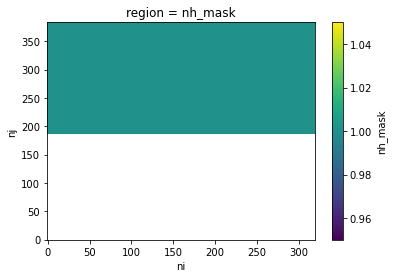

In [5]:
# verify it worked - choose one region to plot
masks.sel(region='nh_mask').plot()

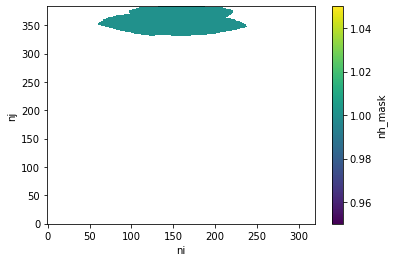

In [6]:
# make a combined mask
reg1 = 'ArcOc_mask'
reg2 = 'Bar_mask'
reg = reg1+'_and_'+reg2
mask_both = masks.sel(region=reg1).fillna(0) + masks.sel(region=reg2).fillna(0)
mask_both = mask_both.where(mask_both == 1)

mask_both.plot()

In [7]:
# Add this mask to the "masks" array
mask_in_new = ['nh_mask', 'Lab_mask', 'GIN_mask', 'Bar_mask', 'ArcOc_mask', 'Sib_mask', 'Beau_mask', 'Bering_mask', 'Hudson_mask', 'CAArch_mask', 'Okhotsk_mask', 'ArcOc_mask_and_Bar_mask']

# new numpy array
masks_tmp = np.zeros([len(mask_in)+1,len(mask_both.nj),len(mask_both.ni)])
# fill it
masks_tmp[0:len(mask_in),:,:] = masks
masks_tmp[len(mask_in),:,:] = mask_both

# convert the numpy array to a xarray
masks_new = xr.DataArray(masks_tmp,dims=('region','nj','ni'))

# set coordinate arrays
masks_new['region'] = mask_in_new
masks_new['nj'] = masks['nj'].values
masks_new['ni'] = masks['ni'].values


In [8]:
# just rename so "new" array is the only array for masking
masks = masks_new

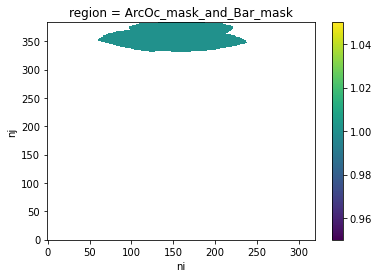

In [9]:
# test this
masks.sel(region='ArcOc_mask_and_Bar_mask').plot()
#masks.sel(region='ArcOc_mask').plot()

## Choose the variable to process

In [51]:
# list the variables to load
var_in = 'hi'

# aice, hi

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [52]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/antarctica_som_env/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [53]:
#cat

In [54]:
forcing = 'cmip6'  # do not want smbb data
exp = 'ssp370' # only want future experiments

subset = cat.search(variable=var_in, forcing_variant=forcing, experiment=exp )

In [55]:
subset

,unique
component,1
stream,1
case,50
member_id,50
variable,1
start_time,9
end_time,9
time_range,9
long_name,1
units,1


In [56]:
# check that we only have cmip6, not smbb, data
member_id = list(subset.df.forcing_variant.unique())
print(member_id)

['cmip6']


In [57]:
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,hi,2015-01,2024-12,201501-202412,grid cell mean ice thickness,m,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,hi,2025-01,2034-12,202501-203412,grid cell mean ice thickness,m,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,hi,2035-01,2044-12,203501-204412,grid cell mean ice thickness,m,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,hi,2045-01,2054-12,204501-205412,grid cell mean ice thickness,m,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,ice,cice.h,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,hi,2055-01,2064-12,205501-206412,grid cell mean ice thickness,m,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/i...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- subset to the time-interval 1950-2100

In [58]:
client

<Client: 'tcp://10.12.206.35:45372' processes=32 threads=64, memory=800.00 GiB>

In [59]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 6.9 s, sys: 117 ms, total: 7.02 s
Wall time: 9.06 s


In [60]:
# print names of the dataset keys. 
dsets.keys()

dict_keys(['ice.ssp370.cice.h.cmip6.hi'])

In [61]:
# Look at just one dataset to see what it looks like. 
# Note that for 1081 there is one member_id, but for 1231 there are 10 member_ids
# these refer to the individual ensemble members!

#dsets['ice.historical.cice.h.cmip6.1081.'+var_in]
#dsets['ice.historical.cice.h.cmip6.1231.'+var_in]

In [62]:
# load in the future datasets

futures = []

for key in sorted(dsets.keys()):
    futures.append(dsets[key])
    print(key)

ice.ssp370.cice.h.cmip6.hi


In [63]:
# Now put these into an array
future_ds = xr.concat(futures, dim='member_id')

In [64]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_all = future_ds

In [65]:
ds_all[var_in]

<xarray.DataArray 'hi' (member_id: 50, time: 1032, nj: 384, ni: 320)>
dask.array<concatenate, shape=(50, 1032, 384, 320), dtype=float32, chunksize=(1, 120, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      grid cell mean ice thickness
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [66]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds

In [67]:
ds_all

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 50, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, time: 1032, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time         (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id    (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, nc) float32 dask.array<chunksize=(50, 5), meta=np.ndarray>
    VGRDi        (member_id, nkice) float32 dask.array<chunksize=(50, 8), meta=np.ndarray>
    VGRDs        (member_id, nksnow) float32 dask.array<chunksize=(50, 3), meta=np.ndarray>
    VGRDb        (member_id, nkbio) float32 dask.array<chunksize=(50, 5), meta=np.ndarray>
    tmask        (member_id, nj, ni) float32 dask.array<chunksize=(50, 384, 320), meta=np.ndarray>
    tarea        (member_id, nj, ni) float32 dask.array<chunksize=(50, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object dask.array<chunksize=(50, 120, 2), meta=np.ndarray>
    hi           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
Attributes:
    history:                 This dataset was created on 2020-04-29 at 18:54\...
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    comment2:                File written on model date 20950201
    time_period_freq:        month_1
    conventions:             CF-1.0
    comment3:                seconds elapsed into model date:      0
    comment:                 All years have exactly 365 days
    contents:                Diagnostic and Prognostic Variables
    intake_esm_varname:      ['hi']
    io_flavor:               io_pio
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ice.ssp370.cice.h.cmip6.hi

In [68]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

<xarray.DataArray 'time_bounds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time       (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    member_id  <U12 'r1i1281p1f1'

In [69]:
ds_all['time'] = ds_all.time_bounds.load().mean(dim='d2').sel(member_id='r1i1281p1f1')

In [70]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [71]:
ds_all

<xarray.Dataset>
Dimensions:      (nj: 384, ni: 320, member_id: 50, nc: 5, nkice: 8, nksnow: 3, nkbio: 5, nvertices: 4, time: 1032, d2: 2)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT         (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id    (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nj, ni, nc, nkice, nksnow, nkbio, nvertices, d2
Data variables: (12/21)
    NCAT         (member_id, nc) float32 dask.array<chunksize=(50, 5), meta=np.ndarray>
    VGRDi        (member_id, nkice) float32 dask.array<chunksize=(50, 8), meta=np.ndarray>
    VGRDs        (member_id, nksnow) float32 dask.array<chunksize=(50, 3), meta=np.ndarray>
    VGRDb        (member_id, nkbio) float32 dask.array<chunksize=(50, 5), meta=np.ndarray>
    tmask        (member_id, nj, ni) float32 dask.array<chunksize=(50, 384, 320), meta=np.ndarray>
    tarea        (member_id, nj, ni) float32 dask.array<chunksize=(50, 384, 320), meta=np.ndarray>
    ...           ...
    lont_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    latt_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    lonu_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    latu_bounds  (member_id, nj, ni, nvertices) float32 dask.array<chunksize=(50, 384, 320, 4), meta=np.ndarray>
    time_bounds  (member_id, time, d2) object 2015-01-01 00:00:00 ... 2101-01...
    hi           (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 384, 320), meta=np.ndarray>
Attributes:
    history:                 This dataset was created on 2020-04-29 at 18:54\...
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    comment2:                File written on model date 20950201
    time_period_freq:        month_1
    conventions:             CF-1.0
    comment3:                seconds elapsed into model date:      0
    comment:                 All years have exactly 365 days
    contents:                Diagnostic and Prognostic Variables
    intake_esm_varname:      ['hi']
    io_flavor:               io_pio
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    intake_esm_dataset_key:  ice.ssp370.cice.h.cmip6.hi

## Apply masks to the dataset

In [72]:
#mask just regions to calculate total ice area and ice volumes
ds_all_masked = ds_all[var_in]*masks

In [73]:
ds_all_masked

<xarray.DataArray (member_id: 50, time: 1032, nj: 384, ni: 320, region: 12)>
dask.array<mul, shape=(50, 1032, 384, 320, 12), dtype=float64, chunksize=(1, 120, 384, 320, 12), chunktype=numpy.ndarray>
Coordinates:
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'ArcOc_mask_and_Bar_mask'

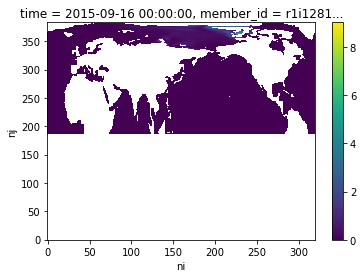

In [74]:
#just test that it worked properly
ds_all_masked.sel(member_id='r1i1281p1f1',region='nh_mask').isel(time=8).plot()

## Calculate regional totals

Total Ice area = sum over lat/lon of (aice*tarea). Units = m2

Ice volume = sum over lat/lon of (hi*tarea). Units = m3

Note that tarea is in cm^2

In [75]:
# get pop grid
grid = pop_tools.get_grid('POP_gx1v7')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60, nreg: 13)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [76]:
# convert tarea to m^2
tarea = grid['TAREA']/(1e4)
tarea=tarea.rename({'nlat':'nj','nlon': 'ni'})

In [77]:
# multiply the values by tarea to get total growth * area(m2) . Units will be cm/day * m2
masked_area = ds_all_masked*tarea

In [78]:
masked_area

<xarray.DataArray (member_id: 50, time: 1032, nj: 384, ni: 320, region: 12)>
dask.array<mul, shape=(50, 1032, 384, 320, 12), dtype=float64, chunksize=(1, 120, 384, 320, 12), chunktype=numpy.ndarray>
Coordinates:
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    TLON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULON       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT       (nj, ni) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'ArcOc_mask_and_Bar_mask'

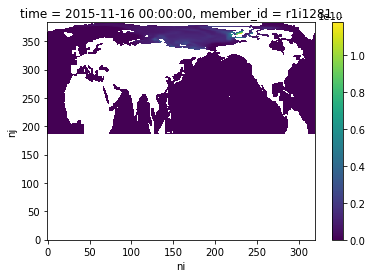

In [79]:
#just test that it worked properly
masked_area.sel(member_id='r1i1281p1f1',region='nh_mask').isel(time=10).plot()

In [80]:
# Get regional totals by summing over both spatial dimensions

# also convert to km2 or km3 depending on the input variable
if var_in == 'aice':
    factor = 1e6
    longname = 'regional total ice area'
    units = 'km^2'
else:
    factor = 1e9
    longname = 'regional total ice volume'
    units = 'km^3'

total = (masked_area.sum(dim='nj').sum(dim='ni'))/factor

### Actually load the data now

Before, all the calculations were "lazy" version

In [81]:
%%time
## slow step
total.load()

CPU times: user 3.89 s, sys: 373 ms, total: 4.26 s
Wall time: 40.2 s


<xarray.DataArray (member_id: 50, time: 1032, region: 12)>
array([[[1.22023271e+04, 8.31596411e+02, 6.88490479e+02, ...,
         1.04394341e+03, 1.21068147e+02, 8.78315902e+03],
        [1.55988682e+04, 1.02362217e+03, 8.24908214e+02, ...,
         1.20718601e+03, 2.33899899e+02, 1.09505679e+04],
        [1.82161919e+04, 1.14433747e+03, 8.95885464e+02, ...,
         1.31807469e+03, 2.54094184e+02, 1.28249052e+04],
        ...,
        [3.60667457e-01, 0.00000000e+00, 3.46943175e-02, ...,
         2.88996530e-02, 0.00000000e+00, 2.97073486e-01],
        [2.52159547e+01, 1.29397616e+00, 5.26441432e+00, ...,
         2.64608875e-06, 0.00000000e+00, 1.57865769e+01],
        [2.88601311e+02, 2.93848388e+01, 4.72573072e+01, ...,
         1.26030630e+01, 0.00000000e+00, 1.90507739e+02]],

       [[1.37383992e+04, 7.56575024e+02, 4.93740033e+02, ...,
         1.17863256e+03, 1.89811494e+02, 1.01690468e+04],
        [1.67752592e+04, 9.71740072e+02, 6.75229957e+02, ...,
         1.33957382e+03, 3.20193823e+02, 1.19854515e+04],
        [1.92038953e+04, 1.10779139e+03, 7.96762465e+02, ...,
         1.44389144e+03, 4.45416220e+02, 1.36345526e+04],
...
        [4.10193951e+00, 3.63097402e-02, 2.26682980e-02, ...,
         1.06636451e+00, 0.00000000e+00, 2.49552367e+00],
        [4.95475512e+01, 4.26746019e+00, 7.79774327e-01, ...,
         3.35670251e+00, 0.00000000e+00, 3.60238381e+01],
        [9.16551399e+02, 3.74332918e+01, 1.67518234e+01, ...,
         8.12554600e+01, 4.78836078e-01, 7.77324153e+02]],

       [[1.38580704e+04, 7.65343443e+02, 7.89026641e+02, ...,
         1.29750847e+03, 1.88495160e+02, 1.01100739e+04],
        [1.71771044e+04, 9.72516651e+02, 9.95346709e+02, ...,
         1.45453021e+03, 3.85976850e+02, 1.20505035e+04],
        [1.95991485e+04, 1.09184274e+03, 1.26836727e+03, ...,
         1.57568109e+03, 4.39948093e+02, 1.34793784e+04],
        ...,
        [2.98862256e+01, 2.99153645e-01, 1.10208563e-02, ...,
         1.69619408e+01, 0.00000000e+00, 1.22097432e+01],
        [7.93728844e+01, 8.91883761e+00, 2.73737168e-01, ...,
         2.11779170e+01, 0.00000000e+00, 4.36139577e+01],
        [6.72125135e+02, 9.13766541e+01, 1.01156713e+01, ...,
         1.38926268e+02, 1.22322038e-01, 4.19384563e+02]]])
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'ArcOc_mask_and_Bar_mask'

In [82]:
total.coords

Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'ArcOc_mask_and_Bar_mask'

In [83]:
total

<xarray.DataArray (member_id: 50, time: 1032, region: 12)>
array([[[1.22023271e+04, 8.31596411e+02, 6.88490479e+02, ...,
         1.04394341e+03, 1.21068147e+02, 8.78315902e+03],
        [1.55988682e+04, 1.02362217e+03, 8.24908214e+02, ...,
         1.20718601e+03, 2.33899899e+02, 1.09505679e+04],
        [1.82161919e+04, 1.14433747e+03, 8.95885464e+02, ...,
         1.31807469e+03, 2.54094184e+02, 1.28249052e+04],
        ...,
        [3.60667457e-01, 0.00000000e+00, 3.46943175e-02, ...,
         2.88996530e-02, 0.00000000e+00, 2.97073486e-01],
        [2.52159547e+01, 1.29397616e+00, 5.26441432e+00, ...,
         2.64608875e-06, 0.00000000e+00, 1.57865769e+01],
        [2.88601311e+02, 2.93848388e+01, 4.72573072e+01, ...,
         1.26030630e+01, 0.00000000e+00, 1.90507739e+02]],

       [[1.37383992e+04, 7.56575024e+02, 4.93740033e+02, ...,
         1.17863256e+03, 1.89811494e+02, 1.01690468e+04],
        [1.67752592e+04, 9.71740072e+02, 6.75229957e+02, ...,
         1.33957382e+03, 3.20193823e+02, 1.19854515e+04],
        [1.92038953e+04, 1.10779139e+03, 7.96762465e+02, ...,
         1.44389144e+03, 4.45416220e+02, 1.36345526e+04],
...
        [4.10193951e+00, 3.63097402e-02, 2.26682980e-02, ...,
         1.06636451e+00, 0.00000000e+00, 2.49552367e+00],
        [4.95475512e+01, 4.26746019e+00, 7.79774327e-01, ...,
         3.35670251e+00, 0.00000000e+00, 3.60238381e+01],
        [9.16551399e+02, 3.74332918e+01, 1.67518234e+01, ...,
         8.12554600e+01, 4.78836078e-01, 7.77324153e+02]],

       [[1.38580704e+04, 7.65343443e+02, 7.89026641e+02, ...,
         1.29750847e+03, 1.88495160e+02, 1.01100739e+04],
        [1.71771044e+04, 9.72516651e+02, 9.95346709e+02, ...,
         1.45453021e+03, 3.85976850e+02, 1.20505035e+04],
        [1.95991485e+04, 1.09184274e+03, 1.26836727e+03, ...,
         1.57568109e+03, 4.39948093e+02, 1.34793784e+04],
        ...,
        [2.98862256e+01, 2.99153645e-01, 1.10208563e-02, ...,
         1.69619408e+01, 0.00000000e+00, 1.22097432e+01],
        [7.93728844e+01, 8.91883761e+00, 2.73737168e-01, ...,
         2.11779170e+01, 0.00000000e+00, 4.36139577e+01],
        [6.72125135e+02, 9.13766541e+01, 1.01156713e+01, ...,
         1.38926268e+02, 1.22322038e-01, 4.19384563e+02]]])
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1301p1f1'
  * region     (region) <U23 'nh_mask' 'Lab_mask' ... 'ArcOc_mask_and_Bar_mask'

### Plot just to check

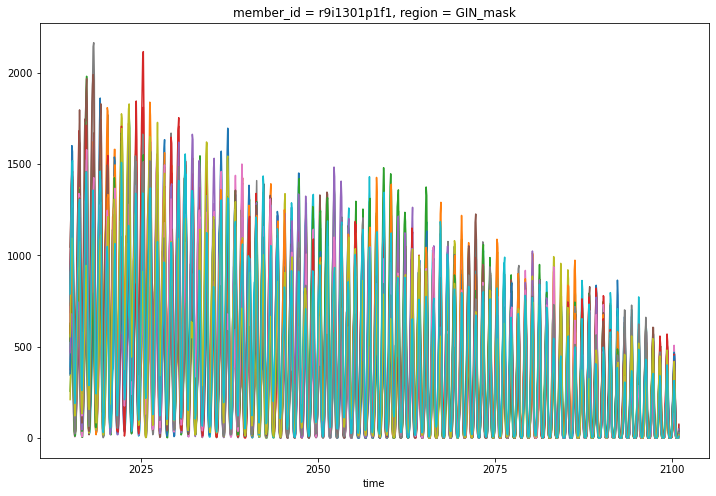

In [84]:
import nc_time_axis
# Setup the figure
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)

# Loop through and plot each member_id all months in 251 years
for member_id in total.member_id.values:
    total.sel(region='GIN_mask',member_id=member_id).plot(ax=ax, label=member_id)

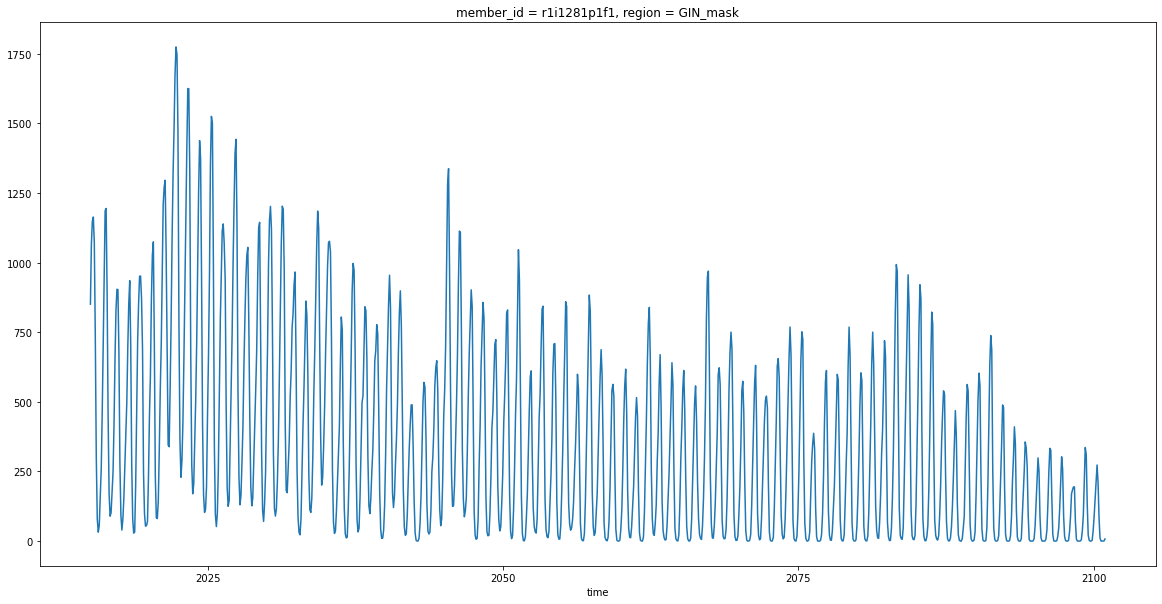

In [85]:
# Setup the figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)

# Plot just one to check
total.sel(region='GIN_mask',member_id='r1i1281p1f1').plot(ax=ax, label='r1i1281p1f1')

### Save the timeseries

In [86]:
fout = 'CESM2-LE_all_transient_regional_avg_'+var_in

In [87]:
ds_to_save = xr.Dataset({'regional_totals': (['member_id','time','region'], total.data)},
                        coords={'time':(['time'],total.time.values),
                                'member_id':(['member_id'],total.member_id.values),
                                'region':(['region'],total.region.values)},
                        attrs={'Author': 'Alice DuVivier', 'units':units, 'longname':longname})

In [88]:
# double check dataset we plan to save
ds_to_save

<xarray.Dataset>
Dimensions:          (member_id: 50, time: 1032, region: 12)
Coordinates:
  * time             (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id        (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
  * region           (region) <U23 'nh_mask' ... 'ArcOc_mask_and_Bar_mask'
Data variables:
    regional_totals  (member_id, time, region) float64 1.22e+04 831.6 ... 419.4
Attributes:
    Author:    Alice DuVivier
    units:     km^3
    longname:  regional total ice volume

In [89]:
ds_to_save.to_netcdf(fout+'.nc')  # how to save file